# Application of Quantum Generative Adversarial Network (QGAN) on High Energy Physics (HEP)

This tutorial demonstrates an advanced usage of the `QGAN` class from Quple on real-world examples in HEP experiments.

### Setup Basic Environments

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install tensorflow==2.4.1
    !pip install tensorflow-quantum
    !pip install quple==0.9.0

In [2]:
import os
import glob
import operator
import numpy as np
import pandas
import h5py
import tensorflow as tf
import tensorflow_quantum as tfq

# Section 0 - Introduction

The dataset used in this tutorial is a set of 32 x 32 images that represent the energy deposition on the detector cells of an electromagnetic calorimeter (ECAL). 

The local geometry of the energy deposition contains information about the properties of the particles that went through the detector cells which is crucial in identifying the particles of origin. 

In this particular dataset, two class of particles are involved: photons (class label "0") and electrons (class label "1"). Each image correspond to a single particle of origin, either photon or electron. In total, there are 498,000 samples, equally distributed between the two classes.

The goal of a quantum GAN model in this case would be to generate images that simulate the given photon/electron images.

One potential application of this model would be to perform fast simulation of ECAL enery deposition which can be used as an alternative to standard Monte Carlo simulators like GEANT4. This is especially useful when the requirement on the quality of the generated samples are less stringent such as for evaluation of ECAL related systematics uncertainties.

# Section 1 - Data Preprocessing

## 1.1 Load Photon-Electron data

Access of the dataset for non-CERN members can be requested [here](https://github.com/ML4SCIHackathon/ML4SCI/tree/main/ParticleImagesChallenge)

In [3]:
# use the cern afs public path or your own path containing the training data
data_dir = "/afs/cern.ch/work/c/chlcheng/public/GSoC2021/data"
photon_path = os.path.join(data_dir, "photon.hdf5")
electron_path = os.path.join(data_dir, "electron.hdf5")

In [4]:
# load photon data
with h5py.File(photon_path, "r") as f:
    px = np.asarray(f['X'][()], dtype=np.float32)[:,:,:,0]
    py = np.asarray(f['y'][()], dtype=np.float32)

# load electron data
with h5py.File(electron_path, "r") as f:
    ex = np.asarray(f['X'][()], dtype=np.float32)[:,:,:,0]
    ey = np.asarray(f['y'][()], dtype=np.float32)

## 1.2 Image Visualization

In [5]:
from quple.utils.visualization import visualize_images
particle_label_map = {
    0: 'photon',
    1: 'electron'
}

#################################################################
Photon energy distribution:


<Figure size 432x288 with 0 Axes>

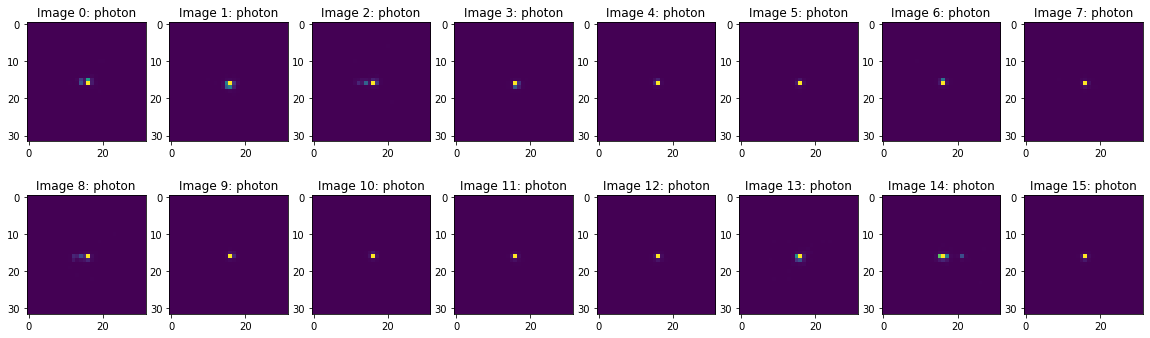

In [7]:
print("#################################################################")
print("Photon energy distribution:")
a = visualize_images(px[:16], labels=py[:16], label_map=particle_label_map)
a.savefig("image_photon_energy_32x32.png", bbox_inches="tight")

#################################################################
Electron energy distribution:


<Figure size 432x288 with 0 Axes>

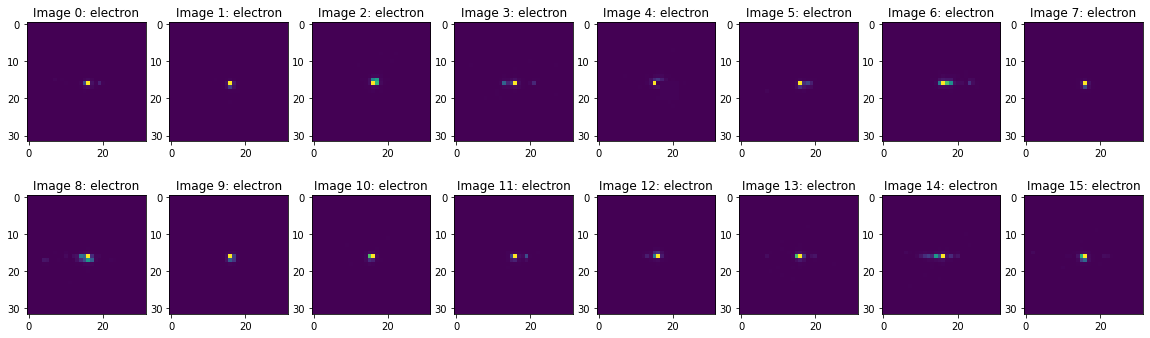

In [8]:
print("#################################################################")
print("Electron energy distribution:")
a = visualize_images(ex[:16], labels=ey[:16], label_map=particle_label_map)
a.savefig("image_electron_energy_32x32.png", bbox_inches="tight")

We can see that the photon and electron energy distributions look very much alike. Both consists of a small central spot with substructure that spans a few pixels wide.

For demonstration purposes, we will just focus on generating the **photon images**.

## 1.3 Prepare Training Dataset

- Let's split the photon dataset into 75% train and 25% test.
- This part is not necessary for GAN training but may be useful if we want to do classification (not included in this tutorial).

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(px, py, train_size=0.75, test_size=0.25, random_state=2021)

## 1.3 Image Cropping

Note that the image is
1. Mostly empty except at the center
2. All distributions are centered and aligned in the same direction (horizontally)

That means we can crop out the central region of the image without losing much information about the jet. And we don't need to rotate the image.

So by inspection, it should be safe to **crop out the central (8x8) grid**.

In [12]:
from quple.utils.data_preparation import crop_images
crop_size = (8, 8)
x_train_cropped = crop_images(x_train, dimension=crop_size)
x_test_cropped = crop_images(x_test, dimension=crop_size)

<Figure size 432x288 with 0 Axes>

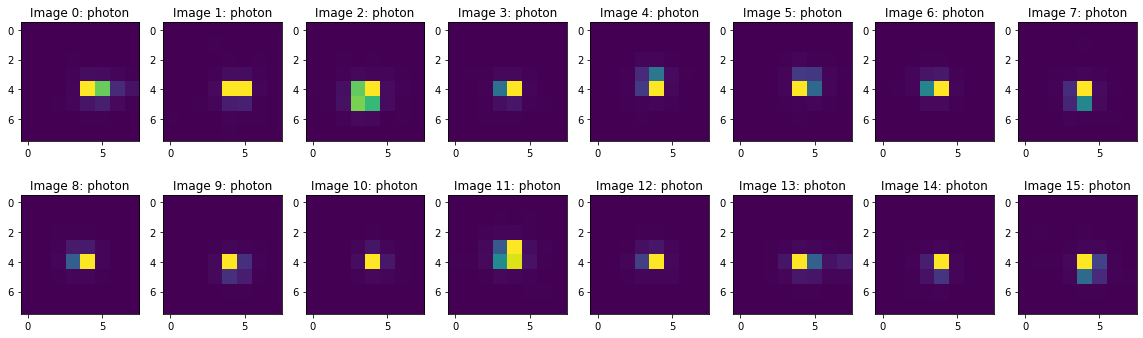

In [13]:
a = visualize_images(x_train_cropped[:16], labels=y_train[:16], label_map=particle_label_map)
a.savefig("image_photon_energy_8x8.png", bbox_inches="tight")

## 1.6 Rescale data to the range appropriate for quantum data encoding

- Usually classical data is encoded as the rotation angle of a gate operation in a quantum circuit which has a valid range of $[-\pi,+\pi]$. However, from past experience a smaller range will suffice and even show better performance than the valid range itself. So for this task, we will be **rescaling our data to a unit range (i.e. $[-1, +1]$)** following the range used by https://arxiv.org/abs/1906.10467. Alternatively, one may also use another common range $[0, +1]$ for example from the`tensorflow_quantum` tutorial for MNIST classification (https://www.tensorflow.org/quantum/tutorials/mnist)

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

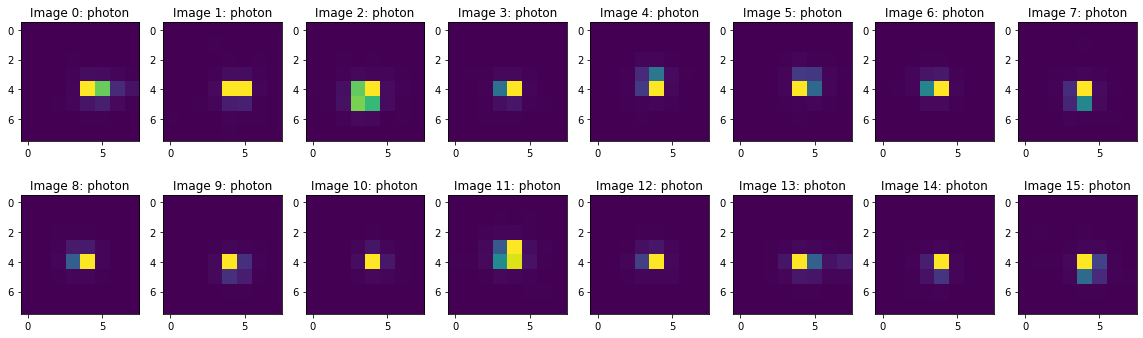

In [11]:
from quple.utils.data_preparation import rescale_data
x_train_rescaled, x_test_rescaled = rescale_data(x_train_cropped, x_test_cropped, val_range=(-1, 1))
visualize_images(x_train_rescaled[:16], labels=y_train[:16], label_map=particle_label_map)

In [12]:
x_train_final = np.reshape(x_train_rescaled, (x_train_rescaled.shape[0], 8, 8))
x_test_final = np.reshape(x_test_rescaled, (x_test_rescaled.shape[0], 8, 8))

# Section 2 - QGAN Model Building

For both generator and discriminator neural networks, we will use the `QConv2D` class for quantum convolution and the `PQC` class for quantum dense network. 

In particular, we will use both 2x2 and 3x3 quantum filters for the quantum convolution. 

The **first-order Pauli Z encoding** with the **identity feature map** is used as the data encoding circuit for the quantum filters as well as the pqc.

Note: The first-order Pauli Z encoding consists of the basic block of one Hadamard layer followed by one single qubit Rz rotation layer that is repeated $k$ times. In our case, $k$ = 2. The identify feature map transform the input data value to the rotation angle via the identity function, i.e. $\theta = f_{Id}(x) = x$.

The **[EfficientSU2](https://qiskit.org/documentation/stubs/qiskit.circuit.library.EfficientSU2.html)** circuit structure is used for the kernel circuit of the quantum filters. It consists of a layer of Ry and Rz rotations followed by a layer of CNOT entanglement that is repeated $k$ times. In our case, $k$ = 2. The linear nearest-neighbor connectivity is used for the CNOT layer.

For the PQC, a custom circuit consisting of a layer of single-qubit Ry and Rz rotations followed by two-qubit ZZ and XX rotations repeated 4 times is used. The rotation angles are parameterized as the tunable neural network weights. 

## 2.1 Quantum Circuit Construction

In [13]:
from quple import ParameterisedCircuit
from quple.data_encoding import FirstOrderPauliZEncoding
from quple.interface.tfq.layers import QConv2D, PQC

In [14]:
data_circuit_2x2 = FirstOrderPauliZEncoding(feature_dimension=4, copies=2, parameter_scale=1)
data_circuit_2x2

(0, 0): ───H───Rz(pi*<x_0/pi>)───H───Rz(pi*<x_0/pi>)───

(0, 1): ───H───Rz(pi*<x_1/pi>)───H───Rz(pi*<x_1/pi>)───

(0, 2): ───H───Rz(pi*<x_2/pi>)───H───Rz(pi*<x_2/pi>)───

(0, 3): ───H───Rz(pi*<x_3/pi>)───H───Rz(pi*<x_3/pi>)───

In [15]:
data_circuit_3x3 = FirstOrderPauliZEncoding(feature_dimension=9, copies=2, parameter_scale=1)
data_circuit_3x3

(0, 0): ───H───Rz(pi*<x_0/pi>)───H───Rz(pi*<x_0/pi>)───

(0, 1): ───H───Rz(pi*<x_1/pi>)───H───Rz(pi*<x_1/pi>)───

(0, 2): ───H───Rz(pi*<x_2/pi>)───H───Rz(pi*<x_2/pi>)───

(0, 3): ───H───Rz(pi*<x_3/pi>)───H───Rz(pi*<x_3/pi>)───

(0, 4): ───H───Rz(pi*<x_4/pi>)───H───Rz(pi*<x_4/pi>)───

(0, 5): ───H───Rz(pi*<x_5/pi>)───H───Rz(pi*<x_5/pi>)───

(0, 6): ───H───Rz(pi*<x_6/pi>)───H───Rz(pi*<x_6/pi>)───

(0, 7): ───H───Rz(pi*<x_7/pi>)───H───Rz(pi*<x_7/pi>)───

(0, 8): ───H───Rz(pi*<x_8/pi>)───H───Rz(pi*<x_8/pi>)───

In [16]:
kernel_circuit_2x2 = ParameterisedCircuit(n_qubit=4, copies=2, 
                                      rotation_blocks=["RY", "RZ"],
                                      entanglement_blocks=["CX"],
                                      entangle_strategy="alternate_linear")
kernel_circuit_2x2

(0, 0): ───Ry(θ_0)───Rz(θ_4)───@───Ry(θ_8)───Rz(θ_12)──────────────@───────
                               │                                   │
(0, 1): ───Ry(θ_1)───Rz(θ_5)───X───@─────────Ry(θ_9)────Rz(θ_13)───X───@───
                                   │                                   │
(0, 2): ───Ry(θ_2)───Rz(θ_6)───@───X─────────Ry(θ_10)───Rz(θ_14)───@───X───
                               │                                   │
(0, 3): ───Ry(θ_3)───Rz(θ_7)───X─────────────Ry(θ_11)───Rz(θ_15)───X───────

In [17]:
kernel_circuit_3x3 = ParameterisedCircuit(n_qubit=9, copies=2, 
                                      rotation_blocks=["RY", "RZ"],
                                      entanglement_blocks=["CX"],
                                      entangle_strategy="alternate_linear")
kernel_circuit_3x3

(0, 0): ───Ry(θ_0)───Rz(θ_9)────@───Ry(θ_18)───Rz(θ_27)──────────────@───────
                                │                                    │
(0, 1): ───Ry(θ_1)───Rz(θ_10)───X───@──────────Ry(θ_19)───Rz(θ_28)───X───@───
                                    │                                    │
(0, 2): ───Ry(θ_2)───Rz(θ_11)───@───X──────────Ry(θ_20)───Rz(θ_29)───@───X───
                                │                                    │
(0, 3): ───Ry(θ_3)───Rz(θ_12)───X───@──────────Ry(θ_21)───Rz(θ_30)───X───@───
                                    │                                    │
(0, 4): ───Ry(θ_4)───Rz(θ_13)───@───X──────────Ry(θ_22)───Rz(θ_31)───@───X───
                                │                                    │
(0, 5): ───Ry(θ_5)───Rz(θ_14)───X───@──────────Ry(θ_23)───Rz(θ_32)───X───@───
                                    │                                    │
(0, 6): ───Ry(θ_6)───Rz(θ_15)───@───X──────────Ry(θ_24)───Rz(θ_33)───@───X───
                                │                                    │
(0, 7): ───Ry(θ_7)───Rz(θ_16)───X───@──────────Ry(θ_25)───Rz(θ_34)───X───@───
                                    │                                    │
(0, 8): ───Ry(θ_8)───Rz(θ_17)───────X──────────Ry(θ_26)───Rz(θ_35)───────X───

In [18]:
pqc_data_circuit = FirstOrderPauliZEncoding(feature_dimension=4, copies=2, parameter_scale=1)
pqc_data_circuit

(0, 0): ───H───Rz(pi*<x_0/pi>)───H───Rz(pi*<x_0/pi>)───

(0, 1): ───H───Rz(pi*<x_1/pi>)───H───Rz(pi*<x_1/pi>)───

(0, 2): ───H───Rz(pi*<x_2/pi>)───H───Rz(pi*<x_2/pi>)───

(0, 3): ───H───Rz(pi*<x_3/pi>)───H───Rz(pi*<x_3/pi>)───

In [19]:
pqc_model_circuit = ParameterisedCircuit(n_qubit=4, copies=4, 
                                      rotation_blocks=["RY", "RZ"],
                                      entanglement_blocks=["ZZ","XX"])
pqc_model_circuit

┌──────────────────┐                                       ┌──────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐
(0, 0): ───Ry(θ_0)───Rz(θ_4)───ZZ─────────ZZ──────────ZZ────────────────────────────────XX──────────XX───────────XX────────────────────────────────Ry(θ_20)────Rz(θ_24)───ZZ──────────ZZ───────────ZZ────────────────────────────────XX──────────XX───────────XX────────────────────────────────Ry(θ_40)────Rz(θ_44)───ZZ──────────ZZ───────────ZZ────────────────────────────────XX──────────XX───────────XX────────────────────────────────Ry(θ_60)────Rz(θ_64)───ZZ──────────ZZ───────────ZZ────────────────────────────────XX──────────XX───────────XX────────────────────────────────────────────
                               │          │           │                                 │           │            │                                                        │           │            │                                 │           │            │                                                        │           │            │                                 │           │            │                                                        │           │            │                                 │           │            │
(0, 1): ───Ry(θ_1)───Rz(θ_5)───ZZ^(θ_8)───┼───────────┼────────ZZ───────────ZZ──────────XX^(θ_14)───┼────────────┼────────XX───────────XX──────────Ry(θ_21)────Rz(θ_25)───ZZ^(θ_28)───┼────────────┼────────ZZ───────────ZZ──────────XX^(θ_34)───┼────────────┼────────XX───────────XX──────────Ry(θ_41)────Rz(θ_45)───ZZ^(θ_48)───┼────────────┼────────ZZ───────────ZZ──────────XX^(θ_54)───┼────────────┼────────XX───────────XX──────────Ry(θ_61)────Rz(θ_65)───ZZ^(θ_68)───┼────────────┼────────ZZ───────────ZZ──────────XX^(θ_74)───┼────────────┼────────XX───────────XX──────────────────────
                                          │           │        │            │                       │            │        │            │                                              │            │        │            │                       │            │        │            │                                              │            │        │            │                       │            │        │            │                                              │            │        │            │                       │            │        │            │
(0, 2): ───Ry(θ_2)───Rz(θ_6)──────────────ZZ^(θ_9)────┼────────ZZ^(θ_11)────┼───────────ZZ──────────XX^(θ_15)────┼────────XX^(θ_17)────┼───────────XX──────────Ry(θ_22)───Rz(θ_26)────ZZ^(θ_29)────┼────────ZZ^(θ_31)────┼───────────ZZ──────────XX^(θ_35)────┼────────XX^(θ_37)────┼───────────XX──────────Ry(θ_42)───Rz(θ_46)────ZZ^(θ_49)────┼────────ZZ^(θ_51)────┼───────────ZZ──────────XX^(θ_55)────┼────────XX^(θ_57)────┼───────────XX──────────Ry(θ_62)───Rz(θ_66)────ZZ^(θ_69)────┼────────ZZ^(θ_71)────┼───────────ZZ──────────XX^(θ_75)────┼────────XX^(θ_77)────┼───────────XX──────────
                                                      │                     │           │                        │                     │           │                                               │                     │           │                        │                     │           │                                               │                     │           │                        │                     │           │                                               │                     │           │                        │                     │           │
(0, 3): ───Ry(θ_3)───Rz(θ_7)──────────────────────────ZZ^(θ_10)─────────────ZZ

In [20]:
# as usual, we measure the last qubit
readout_3x3 = kernel_circuit_3x3.get_gate_operation("Z", -1)
readout_2x2 = kernel_circuit_2x2.get_gate_operation("Z", -1)
PQC_readout = pqc_model_circuit.get_gate_operation("Z", -1)

## 2.2 Quantum Generator and Discriminator Neural Networks


The architecture for the **quantum generator** is as follows:

  1. The input layer takes in an 8x8 image with each pixel value being a random variable sampled from the standard normal distribution.

  2. The first quantum convolution layer (using the `QConv2D` class) with a 3x3 quantum filter with the following settings

    `filters = 1, strides = (1, 1), padding = "same",  parameter_sharing = False`

    The output dimension of this layer is therefore 8 rows x 8 cols x 1 depth = (8, 8, 1).

  3. The second quantum convolution layer (using the `QConv2D` class) with a 2x2 quantum filter with the following settings

    `filters = 1, strides = (1, 1), padding = "same",  parameter_sharing = True`

    The output dimension of this layer is therefore 8 rows x 8 cols x 1 depth = (8, 8, 1).

More information about the settings in the quantum convolution layer can be found in the notebook (T11) or in the code documentation of the `QConv2D` class.

The architecture for the **quantum discriminator** is as follows:

  1. The input layer takes in an 8x8 image coming from either the "fake" image from the generator or the "real" image from the training data.

  2. The first quantum convolution layer (using the `QConv2D` class) with a 3x3 quantum filter with the following settings

    `filters = 3, strides = (1, 1), padding = "same",  parameter_sharing = True`

    The output dimension of this layer is therefore 8 rows x 8 cols x 3 depth = (8, 8, 3).

  3. The second quantum convolution layer (using the `QConv2D` class) with a 2x2 quantum filter with the following settings

    `filters = 1, strides = (2, 2), padding = "same",  parameter_sharing = True`

    The output dimension of this layer is therefore 4 rows x 4 cols x 1 depth = (4, 4, 1).
    
  4. The third quantum convolution layer (using the `QConv2D` class) with a 2x2 quantum filter with the following settings

    `filters = 1, strides = (2, 2), padding = "same",  parameter_sharing = True`

    The output dimension of this layer is therefore 2 rows x 2 cols x 1 depth = (2, 2, 1).
  5. The output PQC layer that performs classifiaction on input data of dimension 2x2=4.

In [21]:
def create_quantum_generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(64), dtype=tf.float32))
    model.add(tf.keras.layers.Reshape((8, 8, 1)))
    model.add(QConv2D(kernel_circuit_3x3, data_circuit_3x3, readout_3x3, kernel_size=(3, 3), 
                      filters=1, strides=(1, 1), padding="same", parameter_sharing=False, seed=2021,
                      ))
    model.add(QConv2D(kernel_circuit_2x2, data_circuit_2x2, readout_2x2, kernel_size=(2, 2), 
                      filters=1, strides=(1, 1), padding="same", parameter_sharing=True, seed=2022,
                      ))
    return model

def create_quantum_discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(8, 8, 1), dtype=tf.float32))
    model.add(QConv2D(kernel_circuit_3x3, data_circuit_3x3, readout_3x3, kernel_size=(3, 3), 
                        filters=3, strides=(1, 1), padding="same", parameter_sharing=True, seed=2023))    
    model.add(QConv2D(kernel_circuit_2x2, data_circuit_2x2, readout_2x2, kernel_size=(2, 2), 
                        filters=1, strides=(2, 2), padding="same", parameter_sharing=True, seed=2023))
    model.add(QConv2D(kernel_circuit_2x2, data_circuit_2x2, readout_2x2, kernel_size=(2, 2), 
                        filters=1, strides=(2, 2), padding="same", parameter_sharing=True, seed=2024))
    model.add(tf.keras.layers.Flatten())
    model.add(PQC(pqc_model_circuit, pqc_data_circuit, PQC_readout, seed=2025))
    return model

In [22]:
from quple.models.generative import QGAN, QWGAN

In [23]:
optimizer_kwargs = {
    "generator": {"learning_rate": 2e-2},
    "discriminator": {"learning_rate": 2e-2}
}
generator = create_quantum_generator()
discriminator = create_quantum_discriminator()
qgan = QGAN(generator, discriminator,
            epochs=50, batch_size=16,
            n_disc=1,
            optimizer="adam",
            optimizer_kwargs=optimizer_kwargs,
            random_state=2021, 
            checkpoint_dir="./training_checkpoints/QGAN/photon_image_8x8")
qgan.enable_visualization((8, 8), n_image=16)

Summary of Generator
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 8, 8, 1)           0         
_________________________________________________________________
q_conv2d (QConv2D)           (None, 8, 8, 1)           2304      
_________________________________________________________________
q_conv2d_1 (QConv2D)         (None, 8, 8, 1)           16        
Total params: 2,320
Trainable params: 2,320
Non-trainable params: 0
_________________________________________________________________
Summary of Discriminator
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
q_conv2d_2 (QConv2D)         (None, 8, 8, 3)           108       
_________________________________________________________________
q_conv2d_3 (QConv2D)         (None, 4, 4, 1)        

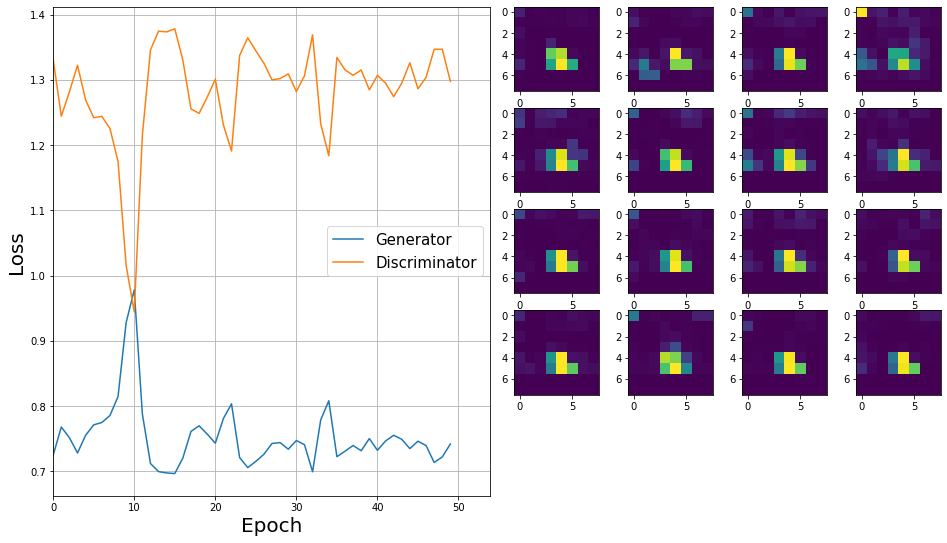

In [26]:
qgan.train(x_train_final[:200])

Below is an animated gif from the above training

<img src="https://gitlab.cern.ch/clcheng/quple/-/raw/master/notebooks/images/QGAN_Photon_8x8.gif" width="1000" align="left"> 

- The QGAN can learn the correct position of the bright spot 
- The generated images lack variety which indicate some degree of mode collapse. This is a common problem in GAN.
- The loss curve is not super smooth due to the aggressive learning rate used. A high learning rate (or order 1e-2) for QGAN usually result in a reasonably good image in a short number of epochs but less stable.

In [24]:
qgan.restore_checkpoint()

Now checkout the generated image from the lastest checkpoint

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

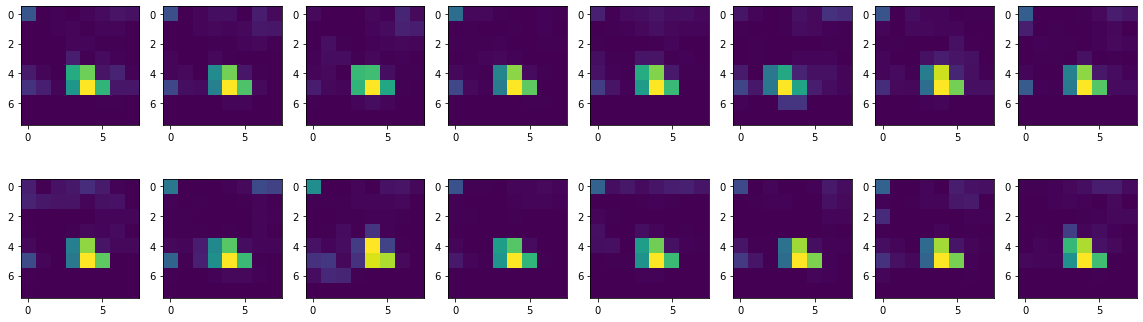

In [25]:
x_gen = qgan.generate_samples(batch_size=16)
visualize_images(x_gen)

Checkout the output patterns from various discriminator convolution layers

In [26]:
qgan.D.layers

In [27]:
x_out_layer_1 = qgan.D.layers[0](x_train_final[:16])
x_out_layer_2 = qgan.D.layers[1](x_out_layer_1)
x_out_layer_3 = qgan.D.layers[2](x_out_layer_2)

In [30]:
x_out_layer_1.shape

TensorShape([16, 8, 8, 3])

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

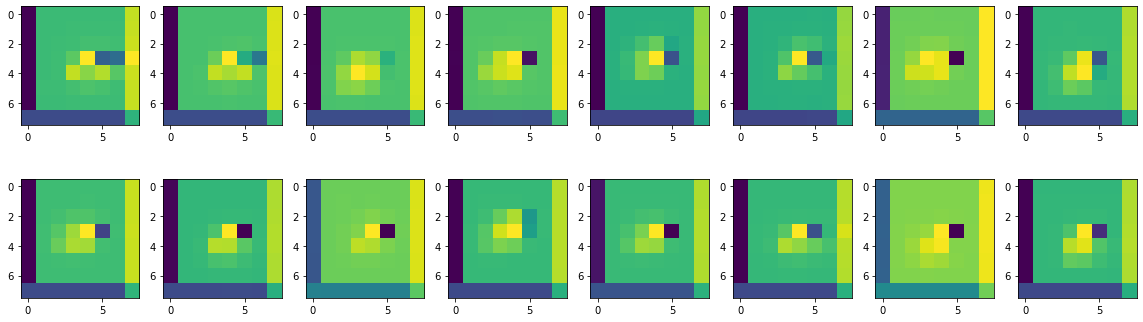

In [31]:
visualize_images(x_out_layer_1[:,:,:,0])

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

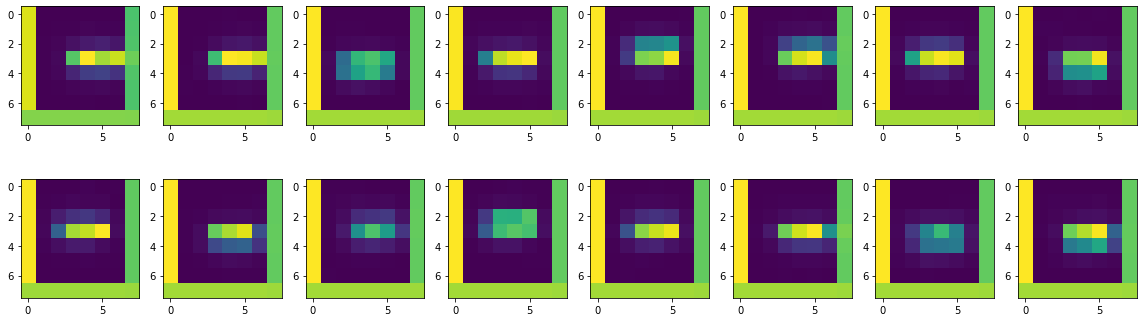

In [32]:
visualize_images(x_out_layer_1[:,:,:,1])

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

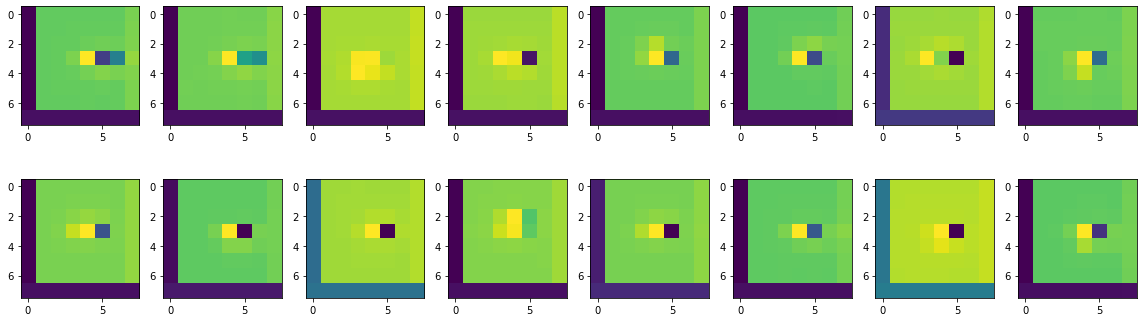

In [33]:
visualize_images(x_out_layer_1[:,:,:,2])

- The distinct edge from the first convolution layer output is due to the zero padding applied to the original image

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

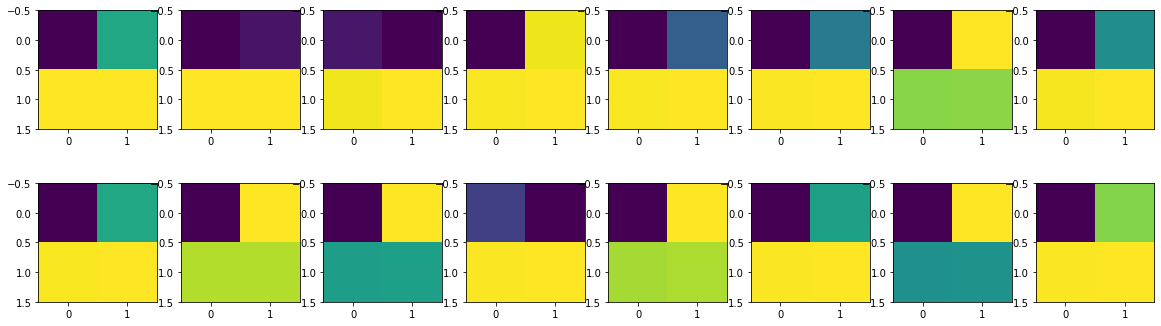

In [28]:
visualize_images(x_out_layer_3)

Now let's try out the Wasserstein GAN architecture

In [27]:
optimizer_kwargs = {
    "generator": {"learning_rate": 2e-2},
    "discriminator": {"learning_rate": 2e-2}
}
generator = create_quantum_generator()
discriminator = create_quantum_discriminator()
qwgan = QWGAN(generator, discriminator,
            epochs=50, batch_size=16,
            n_disc=3,
            optimizer="adam",
            optimizer_kwargs=optimizer_kwargs,
            random_state=2021, 
            checkpoint_dir="./training_checkpoints/QWGAN/photon_image_8x8")
qwgan.enable_visualization((8, 8), n_image=16)

Summary of Generator
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 8, 8, 1)           0         
_________________________________________________________________
q_conv2d_5 (QConv2D)         (None, 8, 8, 1)           2304      
_________________________________________________________________
q_conv2d_6 (QConv2D)         (None, 8, 8, 1)           16        
Total params: 2,320
Trainable params: 2,320
Non-trainable params: 0
_________________________________________________________________
Summary of Discriminator
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
q_conv2d_7 (QConv2D)         (None, 8, 8, 3)           108       
_________________________________________________________________
q_conv2d_8 (QConv2D)         (None, 4, 4, 1)      

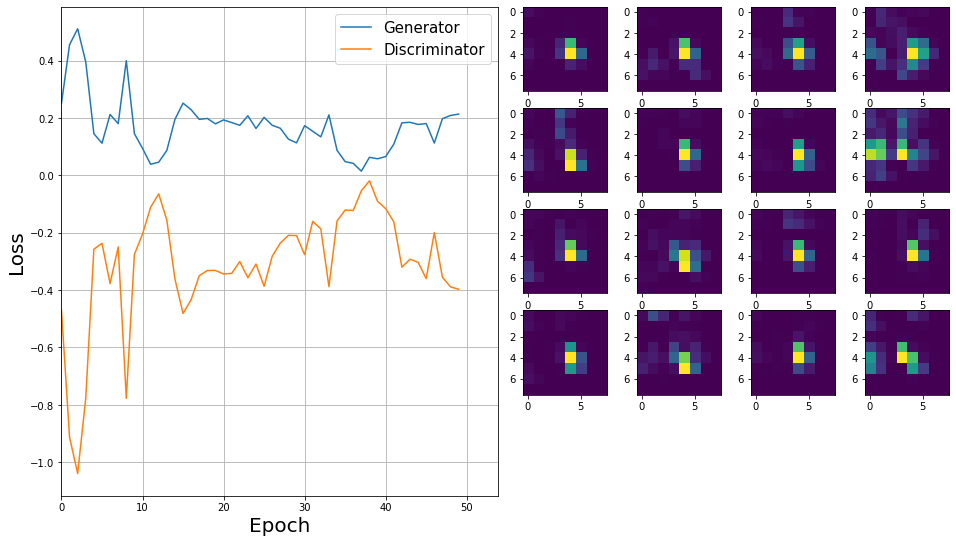

In [28]:
qwgan.train(x_train_final[:500])

Below is an animated gif from the above training

<img src="https://gitlab.cern.ch/clcheng/quple/-/raw/master/notebooks/images/QWGAN_Photon_8x8.gif" width="1000" align="left"> 

- The Wasserstein GAN usually alleviate the problem of mode collapse and we can see more variety in the generated images.

# Secion 3 - Classical GAN

For comparison, we will build a simple classical GAN.

Note: The results may not be reproducible because the random seeds are not set when initializing the model layer weights. 

In [57]:
def create_classical_generator():
    model = tf.keras.Sequential()
    # foundation for 2x2 image
    n_nodes = 64 * 2 * 2
    model.add(tf.keras.layers.Dense(n_nodes, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape((2, 2, 64)))

    model.add(tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(1,1), padding="same", use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    # upsample to 4x4
    model.add(tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding="same", use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())    
    # upsample to 8x8
    model.add(tf.keras.layers.Conv2DTranspose(1, (3,3), strides=(2,2), padding="same", use_bias=False, activation='tanh'))
    return model

def create_classical_discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[8, 8, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (2, 2), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    return model

In [58]:
optimizer_kwargs = {
    "generator": {"learning_rate": 5e-4},
    "discriminator": {"learning_rate": 5e-4}
}
generator = create_classical_generator()
discriminator = create_classical_discriminator()
classical_gan = QGAN(generator, discriminator,
            epochs=70, batch_size=16,
            n_disc=1,
            optimizer="adam",
            optimizer_kwargs=optimizer_kwargs,
            random_state=2021, 
            checkpoint_dir="./training_checkpoints/GAN/photon_image_8x8")
classical_gan.enable_visualization((8, 8), n_image=16)

Summary of Generator
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 256)               25600     
_________________________________________________________________
batch_normalization_27 (Batc (None, 256)               1024      
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
reshape_16 (Reshape)         (None, 2, 2, 64)          0         
_________________________________________________________________
conv2d_transpose_27 (Conv2DT (None, 2, 2, 32)          8192      
_________________________________________________________________
batch_normalization_28 (Batc (None, 2, 2, 32)          128       
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (No

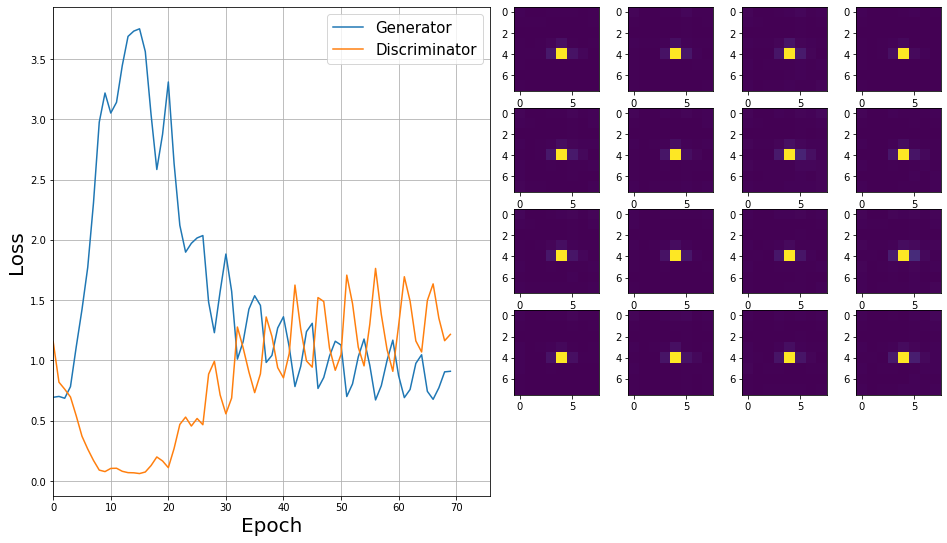

In [59]:
x_train_final_ = np.reshape(x_train_final, (x_train_final.shape[0], 8, 8, 1))
classical_gan.train(x_train_final_[:200])

Below is an animated gif from the above training

<img src="https://gitlab.cern.ch/clcheng/quple/-/raw/master/notebooks/images/ClassicalGAN_Photon_8x8.gif" width="1000" align="left"> 

- The mode collapse problem is apparent in the classical case

For the classical WGAN, one will need to also apply weight-clipping when creating the generator/discriminator neural networks.

This is left as an exercise.

# Secion 4 - GAN with Hybrid Quantum Classical Generator/Discriminator



There are 4 cases:

1. QC - Quantum Generator + Classical Discriminator
2. CQ - Classical Generator + Quantum Discriminator
3. CC - Classical Generator + Classical Discriminator
4. QQ - Quantum Generator + Quantum Discriminator

We will try the "QC" case only for demonstration purpose.

Note: The results may not be reproducible because the random seeds are not set when initializing the model layer weights.

In [68]:
optimizer_kwargs = {
    "generator": {"learning_rate": 1e-2},
    "discriminator": {"learning_rate": 1e-3}
}

generator = create_quantum_generator()
discriminator = create_classical_discriminator()

hybrid_gan = QGAN(generator, discriminator,
            epochs=30, batch_size=16,
            n_disc=1,
            optimizer="adam",
            optimizer_kwargs=optimizer_kwargs,
            random_state=2021, 
            checkpoint_dir="./training_checkpoints/QCGAN/photon_image_8x8")
hybrid_gan.enable_visualization((8, 8), n_image=16)

Summary of Generator
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_21 (Reshape)         (None, 8, 8, 1)           0         
_________________________________________________________________
q_conv2d_15 (QConv2D)        (None, 8, 8, 1)           2304      
_________________________________________________________________
q_conv2d_16 (QConv2D)        (None, 8, 8, 1)           16        
Total params: 2,320
Trainable params: 2,320
Non-trainable params: 0
_________________________________________________________________
Summary of Discriminator
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 4, 4, 64)          640       
_________________________________________________________________
leaky_re_lu_60 (LeakyReLU)   (None, 4, 4, 64)   

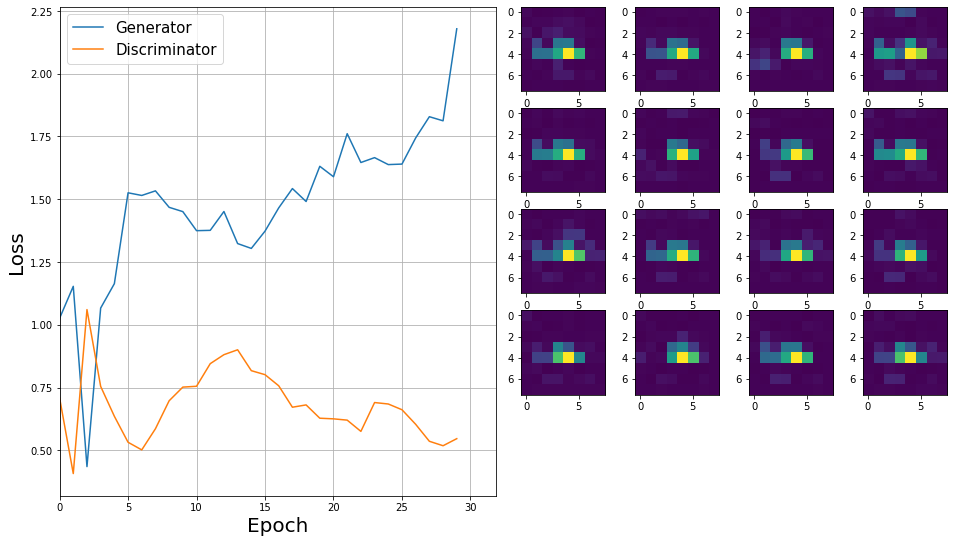

In [69]:
hybrid_gan.train(x_train_final_[:200])

Below is an animated gif from the above training

<img src="https://gitlab.cern.ch/clcheng/quple/-/raw/master/notebooks/images/QCGAN_Photon_8x8.gif" width="1000" align="left"> 